Some STARE functions return Spatial Intervals, which are usually pairs of integers

(start-index-value, terminator)

where start-index-value is the trixel of lowest value in the interval and terminator
is an upper bound. Intervals allow sequences of spatial index values to be 'combined'
or coalesced into a pair. If an interval will only expand (at it's resolution level) 
to the start-index-value, i.e. there's only one trixel in the sequence, then the
terminator is redundant and not stored.

Thus, regions corresponding to multiple intervals can be stored as 1-d arrays of integers
with each interval being one or two elements in an array.

In general, Spatial Intervals correspond to regions that are non-convex and may not
even be contiguous.

Set operations, however, may be performed using intervals without floating point 
geometric calculations.

In this notebook, we construct and plot an interval.

STARE version >= 0.14.2 required.

In [1]:
import pystare as ps

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs

import numpy

In [2]:
# Some helper functions for plotting & printing.

class figax_container(object):
    def __init__(self,figax):
        self.fig = figax[0]
        self.ax  = figax[1]
        return

def add_coastlines(figax,set_global=False):
    "Add coastlines to the plot."
    ax = figax.ax
    if set_global:
        ax.set_global()
    ax.coastlines()
    return figax

def hello_plot(
        spatial_index_values=None
        ,figax=None
        ,plot_options={'projection':ccrs.PlateCarree(),'transform':ccrs.Geodetic()}
        ,set_global=False
        ,show=True
        ):

    if figax is None:
        figax = figax_container(plt.subplots(1,subplot_kw=plot_options))
        if set_global:
            figax.ax.set_global()
        figax.ax.coastlines()
    else:
        ax = figax.ax
    
    if spatial_index_values is not None:
        # Calculate vertices and interconnection matrix
        lons,lats,intmat = ps.triangulate_indices(spatial_index_values)
        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons,lats,intmat)
        figax.ax.triplot(siv_triang,transform=plot_options['transform'])
    
    if show:
        plt.show()
        
    return figax

def hex16(i):
    return "0x%016x"%i

km = 1 # Unit of length



In [3]:
# Set up the projection and transformation
proj         = ccrs.PlateCarree()
# proj        = ccrs.Robinson() # Drives matplotlib bug.
# proj        = ccrs.Mollweide() # Drives matplotlib bug.
transf       = ccrs.Geodetic()
plot_options = {'projection':proj,'transform':transf}

index,term = (0x2c24000000000007,0x2c241fffffffffff)
[19.48772863] [204.65963145]


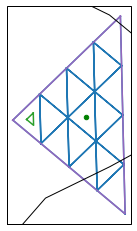

In [4]:
spatial_index_MaunaLoa = 0x2c2401f47797ec4b # Mauna Loa, ~ 5 km
spatial_index_0        = 0x2c24000000000007 # Level 7 ~ 80 km
spatial_term_0         = ps.spatial_terminator(spatial_index_0) # 'last trixel' in spatial_index_0
print("index,term = (%s,%s)"%(hex16(spatial_index_0),hex16(spatial_term_0)))

# get the centroid of the terminator
_,_,centroid_lat,centroid_lon = ps.to_vertices_latlon([spatial_term_0])
print(centroid_lat,centroid_lon)
spatial_interval_0 = numpy.array([spatial_index_0,spatial_term_0],dtype=numpy.int64)

# Expand the interval into resolution level 9 (~20 km) trixels.
# Use a finer resolution to illustrate.
spatial_indices_9 = ps.expand_intervals(spatial_interval_0,9)

# Plot the trixels expanded from the interval (in blue)
figax = hello_plot(spatial_indices_9,show=False)

# Plot M. Loa as a 5 km green triangle (i.e. inside the starting trixel)
figax = hello_plot([spatial_index_MaunaLoa],figax,show=False)

# Plot terminator position as a green dot
figax.ax.scatter(centroid_lon,centroid_lat,s=20,c='g') # The centroid of the last trixel

# Plot coarse triangle the interval covers (purple outline)
figax = hello_plot([spatial_index_0],figax)

# Note the interval, the coarse index value, and the trixels expanded from the interval
# cover the same region or range.

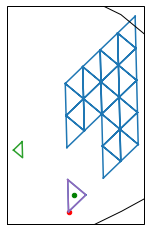

In [6]:
spatial_index_MaunaLoa = 0x2c2401f47797ec4b # Mauna Loa, ~ 5 km

spatial_index_1  = 0x2c2401000000000a  # ~ 10 km trixel about Mauna Loa # The start of the interval
spatial_index_1t = 0x2c241c000000000a  # ~ 10 km trixel # The ending (terminating) trixel of the interval

# get location stored in the ending trixel
lat,lon = ps.to_latlon([spatial_index_1t]) 

# get the centroid of the index neighborhood
_,_,centroid_lat,centroid_lon = ps.to_vertices_latlon([spatial_index_1t]) 

# The 'last trixel' in spatial_index_1t
spatial_term_1  = ps.spatial_terminator(spatial_index_1t)

# An array with an interval
spatial_interval_1 = numpy.array([spatial_index_1,spatial_term_1],dtype=numpy.int64)

# Expand the interval into trixels of level...
spatial_indices = ps.expand_intervals(spatial_interval_1,10)

# Plot the trixels expanded from the interval. ~10 km trixels in blue. Note gap in center.
figax = hello_plot(spatial_indices,show=False)

# Plot the 5 km trixel of Mauna Loa, inside the start of the interval. (green trixel)
figax = hello_plot([spatial_index_MaunaLoa],figax,show=False)

# Plot points associated with the terminating trixel (red and green)
figax.ax.scatter(lon,lat,s=20,c='r') # The location in the last trixel (level 10) in spatial_indices.
figax.ax.scatter(centroid_lon,centroid_lat,s=20,c='g') # The centroid of the last trixel (level 10)

# Coerce the terminator to resolution level 10 and plot (lies between the two
# points scatter-plotted above). Use resolution 10 to match spatial_interval.
figax = hello_plot([ps.spatial_coerce_resolution(spatial_index_1t,10)],figax)

# Note the central gap as the start and terminator of the interval don't 
# cover the entire coarse trixel of the preceeding figure. Essentially arbitrary
# regions can be covered by sets of intervals or index values.